## **Financial Portfolio Analysis in the European Market: Evaluating LSTM and CNN Models for Comparative Insights**

### 1) Loading and Cleaning Data

The dataset will be composed of different stock prices for different european companies that will be extracted directly from yahoo finance using the python function yf.download() avaible in the yfinance package. The data extracted will be put in a dataframe. Then, we will clean the data and make it ready for the analysis.

In [1]:
!pip install yfinance

In [1]:
#load all required libraries
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from scipy.optimize import minimize

In [2]:

# list of companies we want the stocks for
companies = ['SAP', 'ASML', 'NOK', 'VOW3.DE', 'BMW.DE',
             'RDSA.AS', 'TTE', 'ENEL.MI', 'BNP.PA', 'DBK.DE', 'SAN',
             'ULVR', 'NESN.SW', 'OR.PA', 'ROG.SW', 'SNY', 'NOVO-B.CO',
             'ITX.MC', 'CA.PA', 'HM-B.ST', 'IBE.MC', 'EOAN.DE']

# date range for the historical data
start_date = '2010-01-01'
end_date = '2023-01-01'

# build a dataframe
combined_df = pd.DataFrame()

# get the data
for company in companies:
    try:
        print(f"Downloading data for {company}...")
        data = yf.download(company, start=start_date, end=end_date)
        data['Company'] = company
        data.reset_index(inplace=True)
        combined_df = pd.concat([combined_df, data], ignore_index=True)
    except Exception as e:
        print(f"Failed to download data for {company}: {e}")

# handling missing data
combined_df.ffill(inplace=True)
combined_df.dropna(inplace=True)

#index reset
combined_df.reset_index(drop=True, inplace=True)

# Prepare the data for machine learning
ml_df = combined_df[['Date', 'Close', 'Company']]

# Pivot the data so that each company's close price is in a separate column
ml_df = ml_df.pivot(index='Date', columns='Company', values='Close')

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
ml_df_scaled = pd.DataFrame(scaler.fit_transform(ml_df), columns=ml_df.columns, index=ml_df.index)

# Print the first few rows of the scaled DataFrame
print(ml_df_scaled.head())


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['RDSA.AS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
<ipython-input-2-da5b758cfb76>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([combined_df, data], ignore_index=True)


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ULVR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
<ipython-input-2-da5b758cfb76>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([combined_df, data], ignore_index=True)


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Company         ASML    BMW.DE    BNP.PA     CA.PA    DBK.DE   ENEL.MI  \
Date                                                                     
2010-01-04  0.011485  0.036189  0.745800  0.748575  0.823320  0.295560   
2010-01-05  0.011797  0.038957  0.743400  0.776377  0.838474  0.294475   
2010-01-06  0.012167  0.044279  0.745363  0.767570  0.828494  0.304599   
2010-01-07  0.011034  0.047366  0.767183  0.754101  0.832745  0.310385   
2010-01-08  0.010086  0.042629  0.797294  0.765671  0.867305  0.312916   

Company      EOAN.DE   HM-B.ST    IBE.MC    ITX.MC   NESN.SW       NOK  \
Date                                                                     
2010-01-04  0.996035  0.374045  0.413765  0.012225  0.066548  0.835244   
2010-01-05  0.996916  0.370037  0.414577  0.010170  0.052288  0.828080   
2010-01-06  0.991630       NaN  0.413664  0.010312  0.042900  0.820917   
2010-01-07  0.981058  0.363828  0.409299  0.005776  0.036245  0.833095   
2010-01-08  0.994273  0.363263  0.408

Now we will construct the portfolio based on volatility using the beta values, then we will split them into three portfolios: low-risk, moderate-risk, and high-risk portfolios in order to compare their performance.
We will also claculate the sharpe ratio to decide which portfolio is better to invest in.

<ipython-input-3-e031dd220dbd>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  beta_values = pd.concat([beta_values, pd.DataFrame({'Stock': [stock], 'Beta': [beta]})], ignore_index=True)
[                       0%                       ]

Beta values of selected stocks:
        Stock   Beta
0      ULVR.L  0.219
1     NESN.SW  0.336
2       OR.PA  0.711
3   NOVO-B.CO  0.148
4         SAP  0.921
5      BMW.DE  1.076
6      BNP.PA  1.605
7      ITX.MC  1.078
8        ASML  1.052
9      DBK.DE  1.113
10    VOW3.DE  1.234


[*********************100%***********************]  11 of 11 completed
<ipython-input-3-e031dd220dbd>:40: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = price_data.pct_change().dropna()


Returns summary statistics:
Ticker         ASML       BMW.DE       BNP.PA       DBK.DE       ITX.MC  \
count   3359.000000  3359.000000  3359.000000  3359.000000  3359.000000   
mean       0.001171     0.000603     0.000433    -0.000034     0.000516   
std        0.022193     0.018260     0.022811     0.024366     0.016553   
min       -0.173492    -0.129714    -0.174004    -0.184360    -0.105308   
25%       -0.009727    -0.008546    -0.010481    -0.012462    -0.008485   
50%        0.000421     0.000000     0.000000     0.000000     0.000000   
75%        0.012178     0.009658     0.011207     0.012864     0.009275   
max        0.318278     0.144724     0.179808     0.153534     0.140336   

Ticker      NESN.SW    NOVO-B.CO        OR.PA          SAP       ULVR.L  \
count   3359.000000  3359.000000  3359.000000  3359.000000  3359.000000   
mean       0.000383     0.001136     0.000586     0.000437     0.000428   
std        0.009641     0.024921     0.013627     0.016504     0.012249

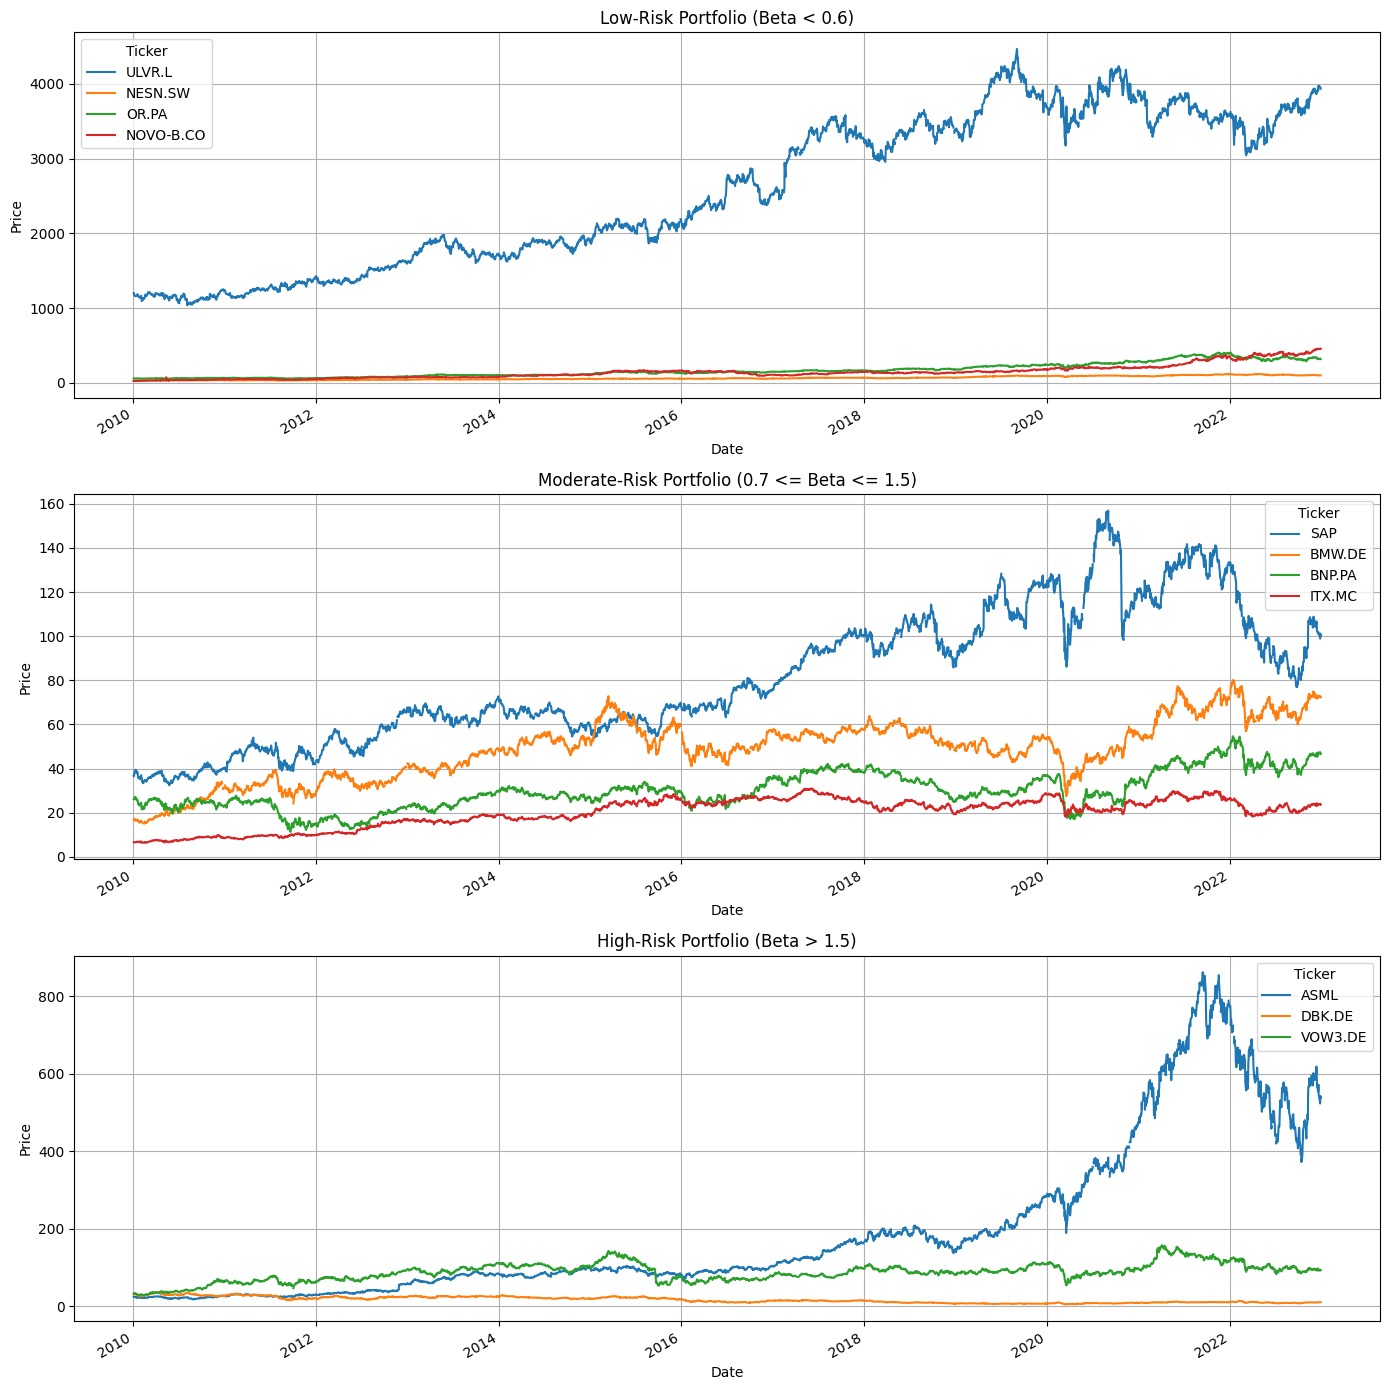

In [3]:

# define 3 stock categories
low_risk_stocks = ['ULVR.L', 'NESN.SW', 'OR.PA', 'NOVO-B.CO']  # low-risk stocks
moderate_risk_stocks = ['SAP', 'BMW.DE', 'BNP.PA', 'ITX.MC']  # moderate-risk stocks
high_risk_stocks = ['ASML', 'DBK.DE', 'VOW3.DE']  # hig-risk stocks
# Combine all the stocks
all_stocks = low_risk_stocks + moderate_risk_stocks + high_risk_stocks

#date range for the historical data
start_date = '2010-01-01'
end_date = '2023-01-01'

#DataFrame to store Beta values
beta_values = pd.DataFrame(columns=['Stock', 'Beta'])

#get data and extract Beta values
for stock in all_stocks:
    try:
        ticker = yf.Ticker(stock)
        beta = ticker.info.get('beta', np.nan)  # Get Beta value
        # Append the beta value using pd.concat
        beta_values = pd.concat([beta_values, pd.DataFrame({'Stock': [stock], 'Beta': [beta]})], ignore_index=True)
    except Exception as e:
        print(f"Failed to fetch data for {stock}: {e}")

#Display the Beta values for all stocks
print("Beta values of selected stocks:")
print(beta_values)

#Download historical price data for all stocks
price_data = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']

# hadling missing values
price_data.dropna(axis=1, how='all', inplace=True)

#daily returns
if price_data.empty:
    print("No price data was downloaded. Please check the stock symbols and try again.")
else:
    # Calculate daily returns
    returns = price_data.pct_change().dropna()

    #Print summary statistics of returns
    print("Returns summary statistics:")
    print(returns.describe())

    #Function to calculate portfolio returns
    def calculate_portfolio_returns(stocks):
        valid_stocks = [stock for stock in stocks if stock in returns.columns]
        if not valid_stocks:
            print(f"No valid stocks found for {stocks}")
            return pd.Series(dtype=float)
        return returns[valid_stocks].mean(axis=1)

    #Calculate portfolio returns
    low_risk_returns = calculate_portfolio_returns(low_risk_stocks)
    moderate_risk_returns = calculate_portfolio_returns(moderate_risk_stocks)
    high_risk_returns = calculate_portfolio_returns(high_risk_stocks)

    print("Sample returns for low-risk portfolio:")
    print(low_risk_returns.head())

    print("Sample returns for moderate-risk portfolio:")
    print(moderate_risk_returns.head())

    print("Sample returns for high-risk portfolio:")
    print(high_risk_returns.head())

    #Calculate Sharpe Ratio
    def calculate_sharpe_ratio(portfolio_returns):
        if portfolio_returns.empty or portfolio_returns.std() == 0:
            print("Returns data is empty or standard deviation is zero.")
            return np.nan  # Avoid division by zero if standard deviation is zero
        risk_free_rate = 0.01 / 252  # Annual risk-free rate converted to daily
        excess_returns = portfolio_returns - risk_free_rate
        sharpe_ratio = np.sqrt(252) * (excess_returns.mean() / excess_returns.std())
        return sharpe_ratio

    low_risk_sharpe = calculate_sharpe_ratio(low_risk_returns)
    moderate_risk_sharpe = calculate_sharpe_ratio(moderate_risk_returns)
    high_risk_sharpe = calculate_sharpe_ratio(high_risk_returns)

    print(f"Low-Risk Portfolio Sharpe Ratio: {low_risk_sharpe}")
    print(f"Moderate-Risk Portfolio Sharpe Ratio: {moderate_risk_sharpe}")
    print(f"High-Risk Portfolio Sharpe Ratio: {high_risk_sharpe}")

    # Plot historical prices for each portfolio
    plt.figure(figsize=(14, 14))

    # Low-risk portfolio
    plt.subplot(3, 1, 1)
    price_data[low_risk_stocks].plot(ax=plt.gca())
    plt.title('Low-Risk Portfolio (Beta < 0.6)')
    plt.ylabel('Price')
    plt.grid(True)

    # Moderate-risk portfolio
    plt.subplot(3, 1, 2)
    price_data[moderate_risk_stocks].plot(ax=plt.gca())
    plt.title('Moderate-Risk Portfolio (0.7 <= Beta <= 1.5)')
    plt.ylabel('Price')
    plt.grid(True)

    # High-risk portfolio
    plt.subplot(3, 1, 3)
    price_data[high_risk_stocks].plot(ax=plt.gca())
    plt.title('High-Risk Portfolio (Beta > 1.5)')
    plt.ylabel('Price')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Now, we will optimize our 3 portfolios based on their sharpe ratios for further analysis and comparison.

Low-Risk Portfolio Optimization Results:
Optimal Weights:
ULVR.L       0.126288
NESN.SW      0.246714
OR.PA        0.333437
NOVO-B.CO    0.293561
dtype: float64
Expected Portfolio Return: 17.07%
Portfolio Standard Deviation: 17.89%
Portfolio Sharpe Ratio: 0.06

Moderate-Risk Portfolio Optimization Results:
Optimal Weights:
SAP       2.565961e-01
BMW.DE    3.893192e-01
BNP.PA    2.949030e-17
ITX.MC    3.540847e-01
dtype: float64
Expected Portfolio Return: 13.34%
Portfolio Standard Deviation: 21.79%
Portfolio Sharpe Ratio: 0.04

High-Risk Portfolio Optimization Results:
Optimal Weights:
ASML       8.697277e-01
DBK.DE     1.734723e-17
VOW3.DE    1.302723e-01
dtype: float64
Expected Portfolio Return: 27.50%
Portfolio Standard Deviation: 32.47%
Portfolio Sharpe Ratio: 0.05



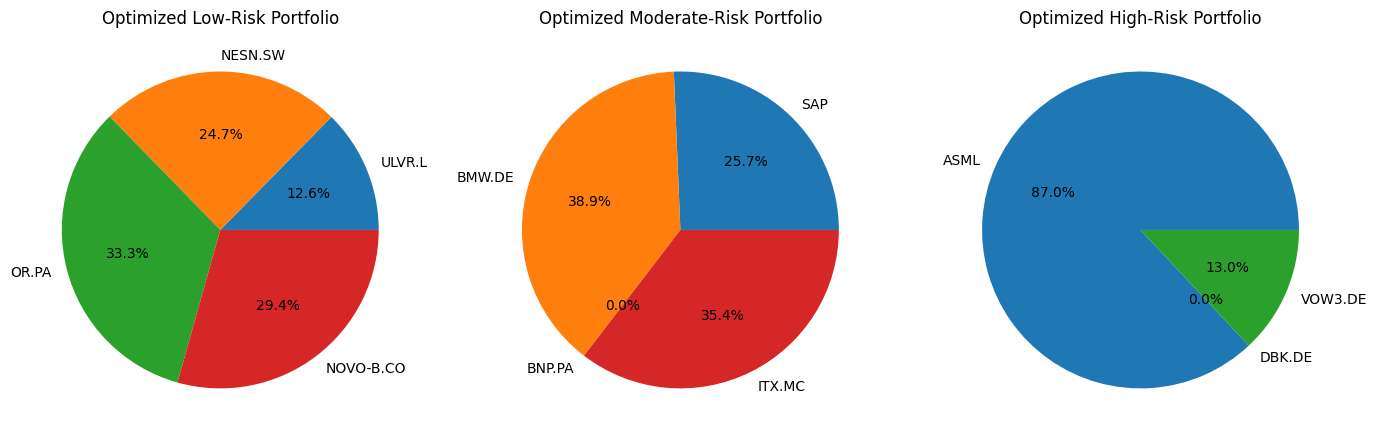

In [4]:

# Define the function to optimize the portfolio based on Sharpe Ratio
def optimize_portfolio(returns, risk_free_rate=0.01 / 252):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_stddev
        return portfolio_return, portfolio_stddev, sharpe_ratio

    def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
        return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

    #setting constraints
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(len(mean_returns)))

    #set initial weights
    initial_weights = len(mean_returns) * [1. / len(mean_returns)]

    # optimizing portfolio by maximizing the Sharpe Ratio (minimizing the negative sharpe)
    opt_results = sco.minimize(negative_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix, risk_free_rate),
                               method='SLSQP', bounds=bounds, constraints=constraints)

    optimal_weights = opt_results.x
    opt_port_return, opt_port_stddev, opt_sharpe_ratio = portfolio_performance(optimal_weights, mean_returns, cov_matrix, risk_free_rate)

    return optimal_weights, opt_port_return, opt_port_stddev, opt_sharpe_ratio

#Optimize Low-Risk Portfolio
low_risk_returns = returns[low_risk_stocks].dropna()
low_risk_optimal_weights, low_risk_return, low_risk_stddev, low_risk_sharpe = optimize_portfolio(low_risk_returns)

#Optimize Moderate-Risk Portfolio
moderate_risk_returns = returns[moderate_risk_stocks].dropna()
moderate_risk_optimal_weights, moderate_risk_return, moderate_risk_stddev, moderate_risk_sharpe = optimize_portfolio(moderate_risk_returns)

#Optimize High-Risk Portfolio
high_risk_returns = returns[high_risk_stocks].dropna()
high_risk_optimal_weights, high_risk_return, high_risk_stddev, high_risk_sharpe = optimize_portfolio(high_risk_returns)

#Printing the results
print("Low-Risk Portfolio Optimization Results:")
print(f"Optimal Weights:\n{pd.Series(low_risk_optimal_weights, index=low_risk_stocks)}")
print(f"Expected Portfolio Return: {low_risk_return*252:.2%}")
print(f"Portfolio Standard Deviation: {low_risk_stddev*np.sqrt(252):.2%}")
print(f"Portfolio Sharpe Ratio: {low_risk_sharpe:.2f}\n")

print("Moderate-Risk Portfolio Optimization Results:")
print(f"Optimal Weights:\n{pd.Series(moderate_risk_optimal_weights, index=moderate_risk_stocks)}")
print(f"Expected Portfolio Return: {moderate_risk_return*252:.2%}")
print(f"Portfolio Standard Deviation: {moderate_risk_stddev*np.sqrt(252):.2%}")
print(f"Portfolio Sharpe Ratio: {moderate_risk_sharpe:.2f}\n")

print("High-Risk Portfolio Optimization Results:")
print(f"Optimal Weights:\n{pd.Series(high_risk_optimal_weights, index=high_risk_stocks)}")
print(f"Expected Portfolio Return: {high_risk_return*252:.2%}")
print(f"Portfolio Standard Deviation: {high_risk_stddev*np.sqrt(252):.2%}")
print(f"Portfolio Sharpe Ratio: {high_risk_sharpe:.2f}\n")

# Plots
plt.figure(figsize=(14, 7))

plt.subplot(1, 3, 1)
plt.pie(low_risk_optimal_weights, labels=low_risk_stocks, autopct='%1.1f%%')
plt.title('Optimized Low-Risk Portfolio')

plt.subplot(1, 3, 2)
plt.pie(moderate_risk_optimal_weights, labels=moderate_risk_stocks, autopct='%1.1f%%')
plt.title('Optimized Moderate-Risk Portfolio')

plt.subplot(1, 3, 3)
plt.pie(high_risk_optimal_weights, labels=high_risk_stocks, autopct='%1.1f%%')
plt.title('Optimized High-Risk Portfolio')

plt.tight_layout()
plt.show()


Now, we will proceed to construct a portfolio using deep learning. First we will use LSTM method, and then we will use CNN method. In the end we will compare to see which method has a better performance in terms of predictions.

[*********************100%***********************]  11 of 11 completed
<ipython-input-5-76680d3bc3f4>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data.fillna(method='ffill', inplace=True)  # Forward fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0376 - val_loss: 0.0095
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0022 - val_loss: 0.0070
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 0.0011 - val_loss: 0.0062
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 8.9267e-04 - val_loss: 0.0058
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 7.8744e-04 - val_loss: 0.0045
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 6.6962e-04 - val_loss: 0.0042
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 6.2520e-04 - val_loss: 0.0036
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 5.8986e-04 - val_loss: 0.0035
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 5.4807e-04 - val_loss: 0.0032
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 4.9735e-04 - val_loss: 0.0033
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 4.9809e-04 - val_loss: 0.0031
Epoch 12/20
75/75 ━━━━━━━━━━━━━

<ipython-input-5-76680d3bc3f4>:72: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


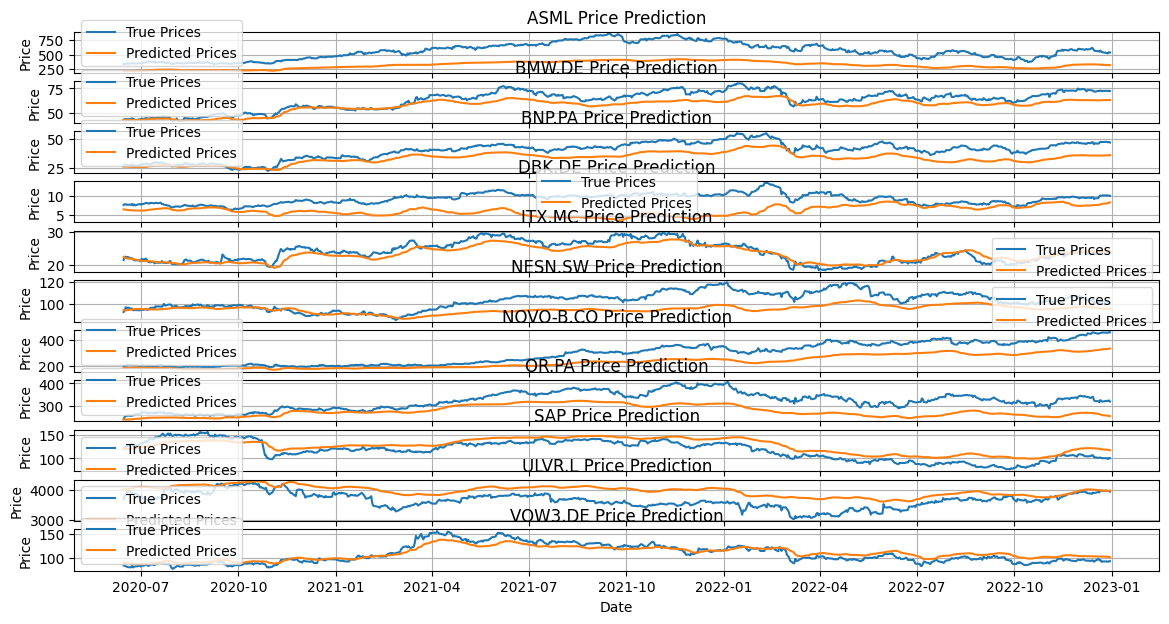

In [5]:

#stock symbols and date range
stocks = ['ASML', 'BMW.DE', 'BNP.PA', 'DBK.DE', 'ITX.MC', 'NESN.SW', 'NOVO-B.CO', 'OR.PA', 'SAP', 'ULVR.L', 'VOW3.DE']
start_date = '2010-01-01'
end_date = '2023-01-01'

#getting the data
price_data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

#handle missing values
price_data.fillna(method='ffill', inplace=True)  # Forward fill

#normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price_data)

#prepare sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 60
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

#Make predictions
y_pred = model.predict(X_test)

#Reverse normalization for predictions
extended_y_pred = np.concatenate([np.zeros((y_pred.shape[0], scaled_data.shape[1] - y_pred.shape[1])), y_pred], axis=1)
y_pred_original = scaler.inverse_transform(extended_y_pred)[:, -y_test.shape[1]:]

#Reverse normalization for actual values
extended_y_test = np.concatenate([np.zeros((y_test.shape[0], scaled_data.shape[1] - y_test.shape[1])), y_test], axis=1)
y_test_original = scaler.inverse_transform(extended_y_test)[:, -y_test.shape[1]:]

#Evaluating the model
mse = mean_squared_error(y_test_original, y_pred_original)
print(f'Mean Squared Error: {mse}')

#plot results
plt.figure(figsize=(14, 7))
for i, stock in enumerate(stocks):
    plt.subplot(len(stocks), 1, i + 1)
    plt.plot(price_data.index[-len(y_test_original):], y_test_original[:, i], label='True Prices')
    plt.plot(price_data.index[-len(y_pred_original):], y_pred_original[:, i], label='Predicted Prices')
    plt.title(f'{stock} Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()



Now, we will visualize the portfolio overall evolution of each stock:

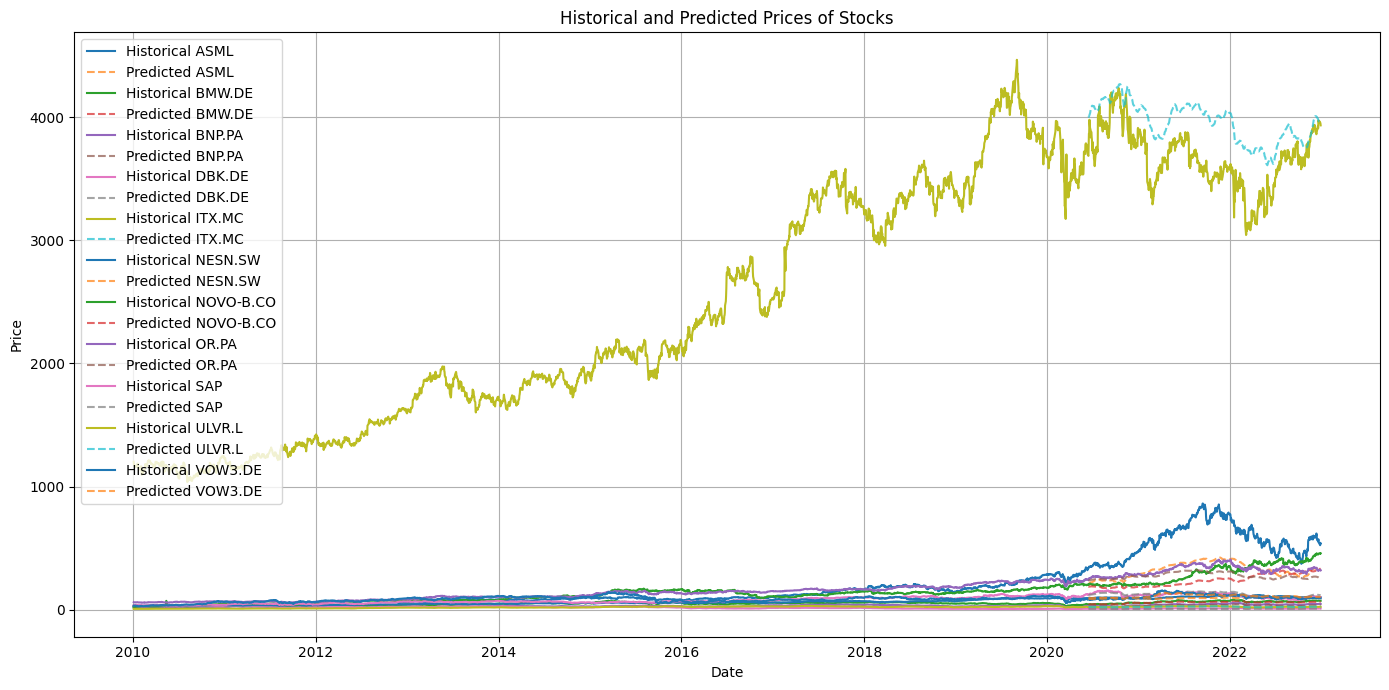

In [6]:

historical_prices_df = price_data.copy()
predicted_prices_df = pd.DataFrame(y_pred_original, columns=stocks, index=price_data.index[-len(y_pred_original):])

#Plot historical prices
plt.figure(figsize=(14, 7))
for stock in stocks:
    plt.plot(historical_prices_df.index, historical_prices_df[stock], label=f'Historical {stock}')
    plt.plot(predicted_prices_df.index, predicted_prices_df[stock], linestyle='--', label=f'Predicted {stock}', alpha=0.7)

#adding titles
plt.title('Historical and Predicted Prices of Stocks')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

#Show the plot
plt.show()

Now, we will optimize our portfolio to get the optimal weights by maximizing the sharpe ratio, then we will predict future portfolio returns.

In [7]:

returns = np.array([0.1])  # Expected returns of assets
cov_matrix = np.array([[0.02]])  # Covariance matrix of asset returns
risk_free_rate = 0.03  # Risk-free rate

#define the objective function (negative Sharpe ratio)
def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    portfolio_return = np.sum(weights * returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio  # Minimize the negative Sharpe ratio

# Constraints
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(returns)))

initial_guess = len(returns) * [1. / len(returns)]

#get optimal solution
optimal_solution = sco.minimize(negative_sharpe_ratio, initial_guess, args=(returns, cov_matrix, risk_free_rate),
                                method='SLSQP', bounds=bounds, constraints=constraints)

#get the optimal weights
optimal_weights = optimal_solution.x

#calculate portfolio performance
optimal_return = np.sum(optimal_weights * returns)
optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
optimal_sharpe_ratio = (optimal_return - risk_free_rate) / optimal_volatility

# Display the results
print("Optimal Portfolio Weights:")
print(optimal_weights)

print("\nOptimal Portfolio Performance:")
print(f"Expected Return: {optimal_return:.2f}")
print(f"Expected Volatility: {optimal_volatility:.2f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.2f}")


Optimal Portfolio Weights:
[1.]

Optimal Portfolio Performance:
Expected Return: 0.10
Expected Volatility: 0.14
Sharpe Ratio: 0.49


[*********************100%***********************]  11 of 11 completed
<ipython-input-1-fd23ff92f572>:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data.fillna(method='ffill', inplace=True)  # Forward fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0340 - val_loss: 0.0131
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0016 - val_loss: 0.0092
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - val_loss: 0.0086
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.6201e-04 - val_loss: 0.0072
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4114e-04 - val_loss: 0.0059
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3704e-04 - val_loss: 0.0048
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.1920e-04 - val_loss: 0.0042
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8423e-04 - val_loss: 0.0039
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1110e-04 - val_loss: 0.0035
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6844e-04 - val_loss: 0.0035
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.4430e-04 - val_loss: 0.0042
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 

<ipython-input-1-fd23ff92f572>:92: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


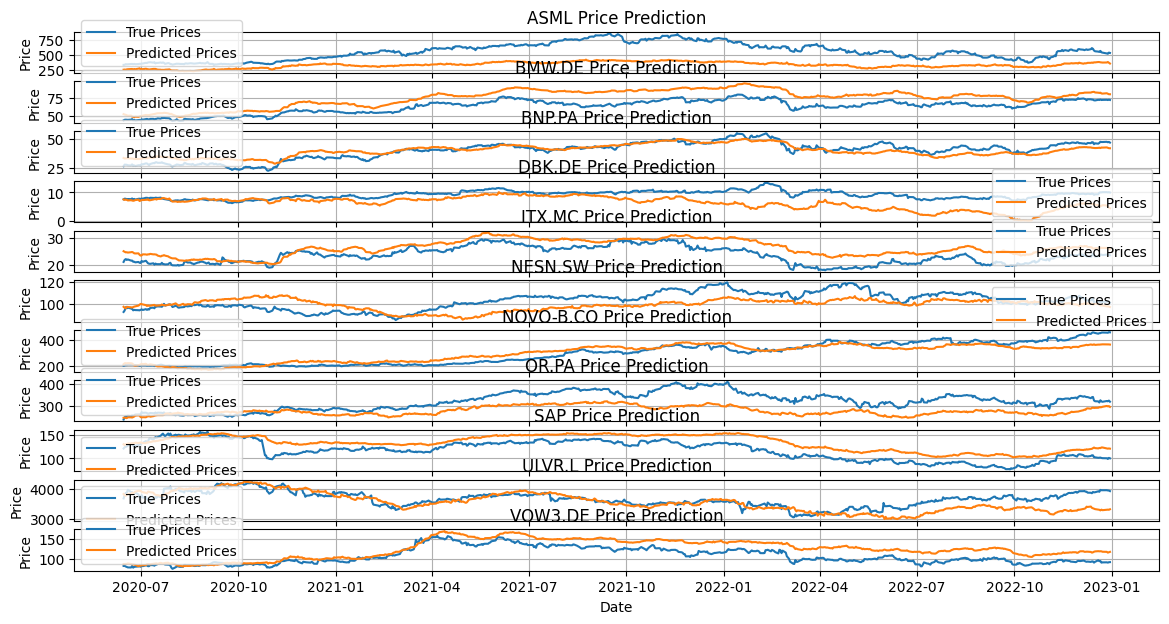

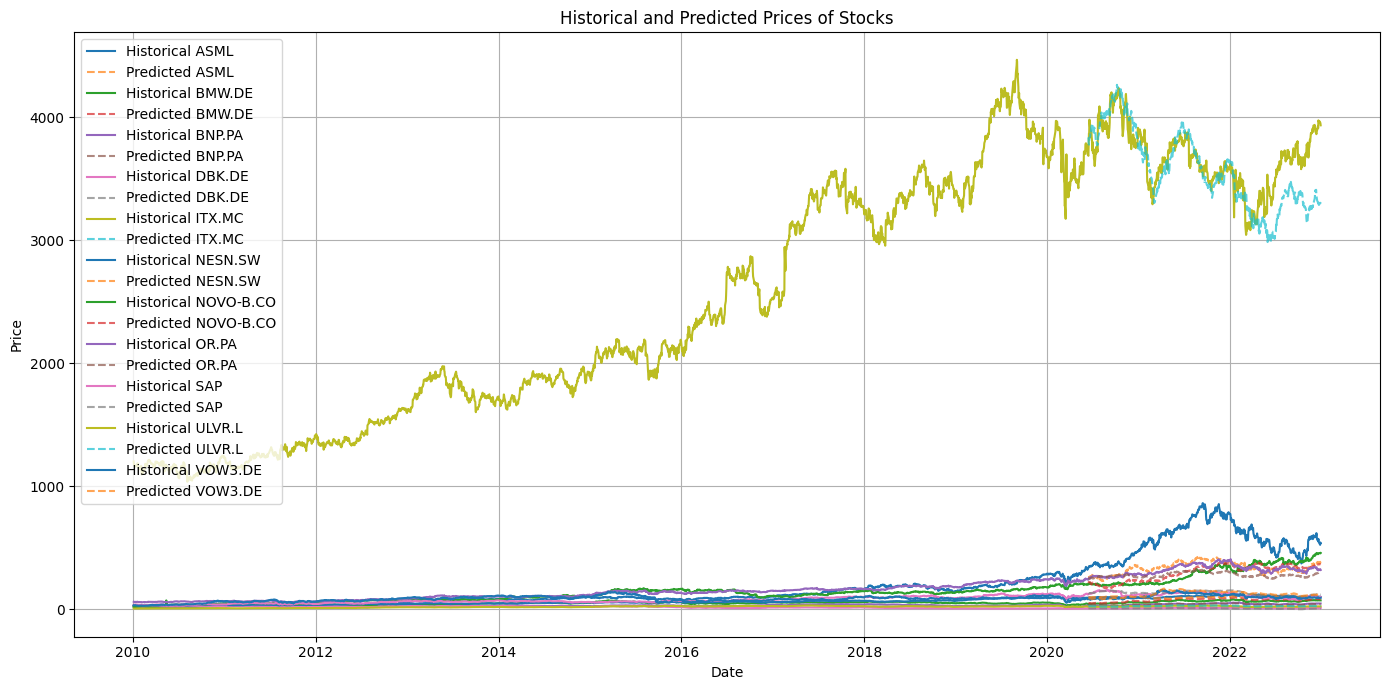

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten

# Stock symbols and date range
stocks = ['ASML', 'BMW.DE', 'BNP.PA', 'DBK.DE', 'ITX.MC', 'NESN.SW', 'NOVO-B.CO', 'OR.PA', 'SAP', 'ULVR.L', 'VOW3.DE']
start_date = '2010-01-01'
end_date = '2023-01-01'

# Getting the data
price_data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

# Handle missing values
price_data.fillna(method='ffill', inplace=True)  # Forward fill

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price_data)

# Prepare sequences for CNN
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 60  # Sequence length (60 days)
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into training and test sets (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for CNN (CNN expects input with shape (samples, time steps, features))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build the CNN model
model = Sequential()

# Add a 1D Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(SEQ_LENGTH, X_train.shape[2])))

# Flatten the output to prepare for the Dense layer
model.add(Flatten())

# Dense output layer for predicting future stock prices
model.add(Dense(y_train.shape[1]))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Reverse normalization for predictions
extended_y_pred = np.concatenate([np.zeros((y_pred.shape[0], scaled_data.shape[1] - y_pred.shape[1])), y_pred], axis=1)
y_pred_original = scaler.inverse_transform(extended_y_pred)[:, -y_test.shape[1]:]

# Reverse normalization for actual values
extended_y_test = np.concatenate([np.zeros((y_test.shape[0], scaled_data.shape[1] - y_test.shape[1])), y_test], axis=1)
y_test_original = scaler.inverse_transform(extended_y_test)[:, -y_test.shape[1]:]

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test_original, y_pred_original)
print(f'Mean Squared Error: {mse}')

# Plot the results for each stock
plt.figure(figsize=(14, 7))
for i, stock in enumerate(stocks):
    plt.subplot(len(stocks), 1, i + 1)
    plt.plot(price_data.index[-len(y_test_original):], y_test_original[:, i], label='True Prices')
    plt.plot(price_data.index[-len(y_pred_original):], y_pred_original[:, i], label='Predicted Prices')
    plt.title(f'{stock} Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Historical prices
historical_prices_df = price_data.copy()

# Predicted prices
predicted_prices_df = pd.DataFrame(y_pred_original, columns=stocks, index=price_data.index[-len(y_pred_original):])

# Plot historical prices vs predicted prices
plt.figure(figsize=(14, 7))
for stock in stocks:
    plt.plot(historical_prices_df.index, historical_prices_df[stock], label=f'Historical {stock}')
    plt.plot(predicted_prices_df.index, predicted_prices_df[stock], linestyle='--', label=f'Predicted {stock}', alpha=0.7)

# Add titles and labels
plt.title('Historical and Predicted Prices of Stocks')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


Optimized Portfolio Weights:
ASML: 0.0809
BMW.DE: 0.0829
BNP.PA: 0.0839
DBK.DE: 0.2195
ITX.MC: 0.0760
NESN.SW: 0.0741
NOVO-B.CO: 0.0809
OR.PA: 0.0741
SAP: 0.0734
ULVR.L: 0.0717
VOW3.DE: 0.0827
Optimized Portfolio Return: 0.0004
Optimized Portfolio Volatility: 0.0129
Optimized Sharpe Ratio: -0.7507


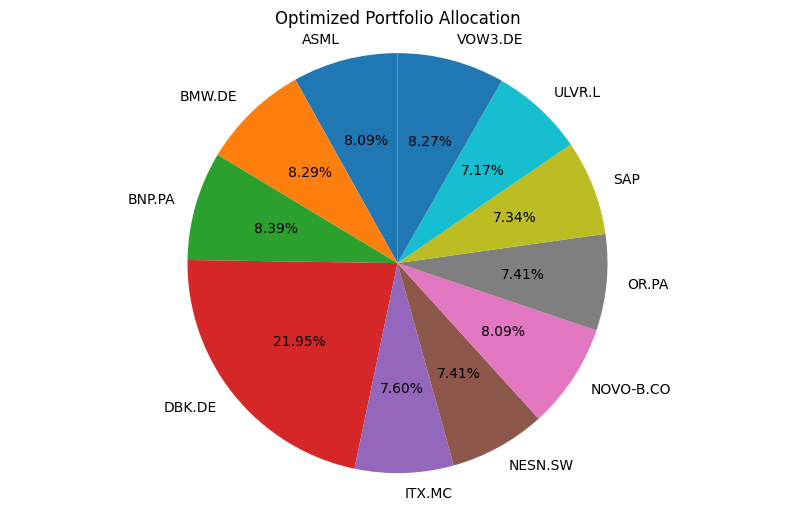

In [4]:
# Regularization term to penalize large allocations
def sharpe_ratio_with_penalty(weights, mean_returns, cov_matrix, risk_free_rate=0.01, penalty=10):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    # Add a penalty for large allocations to prevent concentration in a single stock
    penalty_term = penalty * np.sum(weights**2)  # Penalize large allocations
    return -(sharpe_ratio - penalty_term)

# Constraints: Weights sum to 1, and no shorting (weights >= 0)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 0.3) for _ in range(len(stocks)))  # Limit max weight to 30%

# Initial guess (equal allocation)
initial_guess = len(stocks) * [1. / len(stocks)]

# Optimization with regularization
opt_results = sco.minimize(sharpe_ratio_with_penalty, initial_guess, args=(mean_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal portfolio weights
optimal_weights = opt_results.x

# Print optimized portfolio weights
print("Optimized Portfolio Weights:")
for stock, weight in zip(stocks, optimal_weights):
    print(f"{stock}: {weight:.4f}")

# Evaluate optimized portfolio
optimized_return = np.sum(mean_returns * optimal_weights)
optimized_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
optimized_sharpe_ratio = (optimized_return - 0.01) / optimized_volatility

print(f"Optimized Portfolio Return: {optimized_return:.4f}")
print(f"Optimized Portfolio Volatility: {optimized_volatility:.4f}")
print(f"Optimized Sharpe Ratio: {optimized_sharpe_ratio:.4f}")

# Plot the optimized portfolio allocation
plt.figure(figsize=(10, 6))
plt.pie(optimal_weights, labels=stocks, autopct='%1.2f%%', startangle=90)
plt.title('Optimized Portfolio Allocation')
plt.axis('equal')
plt.show()


